In [237]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from functools import *
from itertools import *
from pathlib import Path
from PIL import Image
import random
import csv
from ast import literal_eval
plt.style.use('seaborn-whitegrid')
import sys
np.set_printoptions(threshold = sys.maxsize)
import time


/tmp/ipykernel_154290/245364182.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [257]:

# ensure transforms are inverses
# Functions to map between cartesian coordinates and array indexes
def cartesian_to_array(x, y, shape):
    m, n = shape[:2]
    i = (n - 1) // 2 - y
    j = (n - 1) // 2 + x
    if i < 0 or i >= m or j < 0 or j >= n:
        raise ValueError("Coordinates not within given dimensions.")
    return i, j


def array_to_cartesian(i, j, shape):
    m, n = shape[:2]
    if i < 0 or i >= m or j < 0 or j >= n:
        raise ValueError("Coordinates not within given dimensions.")
    y = (n - 1) // 2 - i
    x = j - (n - 1) // 2
    return x, y


point = (1, 8)
shape = (9, 9, 3)
assert cartesian_to_array(*array_to_cartesian(*point, shape), shape) == point


# Functions to map an image between array and record formats
def image_to_dict(image):
    image = np.atleast_3d(image)
    kv_image = {}
    for i, j in product(range(len(image)), repeat=2):
        kv_image[array_to_cartesian(i, j, image.shape)] = tuple(image[i, j])
    return kv_image


def image_to_df(image):
    return pd.DataFrame(
        [(x, y, r, g, b) for (x, y), (r, g, b) in image_to_dict(image).items()],
        columns=['x', 'y', 'r', 'g', 'b']
    )


def df_to_image(df):
    side = int(len(df) ** 0.5)  # assumes a square image
    return df.set_index(['x', 'y']).to_numpy().reshape(side, side, -1)

def get_direction(u, v):
    """Returns the sign of the angle from u to v."""
    direction = np.sign(np.cross(u, v))
    if direction == 0 and np.dot(u, v) < 0:
        direction = 1
    return direction


# We don't use this elsewhere, but you might find it useful."""
def get_angle(u, v):
    """Returns the angle (in degrees) from u to v."""
    return np.degrees(np.math.atan2(
        np.cross(u, v),
        np.dot(u, v),
    ))

# compress a path between two points
# def compress_path(path):
#     r = [[] for _ in range(8)]
#     for p in path:
#         for i in range(8):
#             if len(r[i]) == 0 or r[i][-1] != p[i]:
#                 r[i].append(p[i])
#     mx = max([len(x) for x in r])

#     for rr in r:
#         while len(rr) < mx:
#             rr.append(rr[-1])
#     r = list(zip(*r))

#     for i in range(len(r)):
#         r[i] = list(r[i])

#     return r
def compress_path(path):
    
    if len(path) > 2:
        
        new_path = []
        
        max_conf_dist = 1
        
        r = [[] for _ in range(len(path[0]))]
        
        for p in path:
            for i, c in enumerate(p):

                if len(r[i]) == 0 or r[i][-1] != c:
                    
                    if c not in r[i]:
                        r[i].append(c)
                    else:
                        r[i] = r[i][:r[i].index(c) + 1]
                        
                    assert r[i][-1] == c
        
        max_conf_dist = max([len(r_) for r_ in r])
        
        for i in range(max_conf_dist):
            
            new_conf = []
            
            for _, r_ in enumerate(r):
                
                if i < len(r_):
                    c_ = r_[i]
                else:
                    c_ = r_[-1]
                
                new_conf.append(c_)
            
            new_path.append(new_conf)
            
        return new_path
                               
        
    return path

def get_path_to_point(config, point):
    """Find a path of configurations to `point` starting at `config`."""
    path = [config]
    # Rotate each link, starting with the largest, until the point can
    # be reached by the remaining links. The last link must reach the
    # point itself.
    for i in range(len(config)):
        link = config[i]
        base = get_position(config[:i])
        relbase = (point[0] - base[0], point[1] - base[1])
        position = get_position(config[:i+1])
        relpos = (point[0] - position[0], point[1] - position[1])
        radius = reduce(lambda r, link: r + max(abs(link[0]), abs(link[1])), config[i+1:], 0)
        # Special case when next-to-last link lands on point.
        if radius == 1 and relpos == (0, 0):
            config = rotate(config, i, 1)
            if get_position(config) == point:  # Thanks @pgeiger
                path.append(config)
                break
            else:
                continue
        while np.max(np.abs(relpos)) > radius:
            direction = get_direction(link, relbase)
            config = rotate(config, i, direction)
            path.append(config)
            link = config[i]
            base = get_position(config[:i])
            relbase = (point[0] - base[0], point[1] - base[1])
            position = get_position(config[:i+1])
            relpos = (point[0] - position[0], point[1] - position[1])
            radius = reduce(lambda r, link: r + max(abs(link[0]), abs(link[1])), config[i+1:], 0)
    assert get_position(path[-1]) == point
    path = compress_path(path)
    return path

def plot_configuration(config, image=None, ax=None, color='0.25', **figure_args):
    def get_position(config):
        return reduce(lambda p, q: (p[0] + q[0], p[1] + q[1]), config, (0, 0))

    if ax is None:
        _, ax = plt.subplots(**figure_args)

    k = 2 ** (len(config) - 1) + 1
    X, Y = (np.vstack([[(0, 0)], np.asarray(config).cumsum(axis=0)])[:-1].T - 0.5)
    U, V = np.asarray(config).T
    ax.quiver(
        X, Y, U, V,
        angles='xy', scale_units='xy', scale=1,
        color=color,
        width=0.005,
        zorder=10,
    )
    point = get_position(config)
    ax.plot(point[0]-0.5, point[1]-0.5, '.', color='k', zorder=11)
    if image is not None:
        ax.matshow(image, extent=[-k-1, k, -k-1, k])
    ax.set_xlim(-k-1, k)
    ax.set_ylim(-k-1, k)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(-k, k+1))
    ax.set_yticks(np.arange(-k, k+1))
    return ax

def get_position(config):
    return reduce(lambda p, q: (p[0] + q[0], p[1] + q[1]), config, (0, 0))

def rotate_link(vector, direction):
    x, y = vector
    if direction == 1:  # counter-clockwise
        if y >= x and y > -x:
            x -= 1
        elif y > x and y <= -x:
            y -= 1
        elif y <= x and y < -x:
            x += 1
        else:
            y += 1
    elif direction == -1:  # clockwise
        if y > x and y >= -x:
            x += 1
        elif y >= x and y < -x:
            y += 1
        elif y < x and y <= -x:
            x -= 1
        else:
            y -= 1
    return (x, y)


def rotate(config, i, direction):
    config = config.copy()
    config[i] = rotate_link(config[i], direction)
    return config


def get_square(link_length):
    link = (link_length, 0)
    coords = [link]
    for _ in range(8 * link_length - 1):
        link = rotate_link(link, direction=1)
        coords.append(link)
    return coords

def get_neighbors(config):
    nhbrs=[]
    for directions in product((-1, 0, 1), repeat=len(config)):
        currconfig = reduce(lambda x, y: rotate(x, *y), enumerate(directions), config)
        if pix_map[cartesian_to_array(*get_position(currconfig),image.shape)]==1:
            continue;
        else:    
            nhbrs += [(currconfig)]
    return list(filter(lambda c: c != config, nhbrs))


# Functions to compute the cost function

# Cost of reconfiguring the robotic arm: the square root of the number of links rotated
def reconfiguration_cost(from_config, to_config):
    nlinks = len(from_config)
    diffs = np.abs(np.asarray(from_config) - np.asarray(to_config)).sum(axis=1)
    return np.sqrt(diffs.sum())


# Cost of moving from one color to another: the sum of the absolute change in color components
def color_cost(from_position, to_position, image, color_scale=3.0):
    return np.abs(image[to_position] - image[from_position]).sum() * color_scale


# Total cost of one step: the reconfiguration cost plus the color cost
def step_cost(from_config, to_config, image):
    from_position = cartesian_to_array(*get_position(from_config), image.shape)
    to_position = cartesian_to_array(*get_position(to_config), image.shape)
    return (
        reconfiguration_cost(from_config, to_config) +
        color_cost(from_position, to_position, image)
    )

In [84]:
# Compute total cost of path over image
def total_cost(path, image):
    return reduce(
        lambda cost, pair: cost + step_cost(pair[0], pair[1], image),
        zip(path[:-1], path[1:]),
        0,
    )


In [3]:
config = [[(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)]]

In [4]:
df_img = pd.read_csv('image.csv')
image = df_to_image(df_img)
assert image_to_df(image).equals(df_img) 
pix_map = np.zeros((257,257))
pix_map[cartesian_to_array(*get_position(config[-1]),image.shape)] = 1

In [5]:
np.where(pix_map==1)

(array([128]), array([128]))

In [6]:
config[-1]

[(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)]

In [7]:
#hyperparams of costs_prob
m =5
l =5

#things to try, turn off the really bad costs,when a costs of <1.5 exists only keep those costs, or alter the costs to give those costs a 97.5 % chance of being chosen

In [258]:
def get_path_to_configuration(from_config, to_config):
    path = [from_config]
    config = from_config.copy()
    while config != to_config:
        for i in range(len(config)):
            config = rotate(config, i, get_direction(config[i], to_config[i]))
        path.append(config)
    assert path[-1] == to_config
    path = compress_path(path)
    return path

In [52]:
def pixel_search(pmap,curr_pos,search_size):
    assert search_size>2 and search_size % 2 !=0
    lb_x = curr_pos[0]-search_size//2
    lb_y = curr_pos[1] - search_size//2
    ub_x = curr_pos[0]+search_size//2+1
    ub_y = curr_pos[1]+search_size//2+1

    if (curr_pos[0] - search_size//2)<0:
        lb_x = 0
    if (curr_pos[1] - search_size//2)<0:
        lb_y = 0  


    x_,y_ = np.where(pmap[lb_x:ub_x,lb_y:ub_y]==0)
    return np.column_stack((x_+lb_x,y_+lb_y))
    

In [263]:
fin=0

In [264]:


while True:
    if fin ==1:
        config = [[(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)]]
        pix_map = np.zeros((257,257))
        pix_map[cartesian_to_array(*get_position(config[-1]),image.shape)] = 1
        fin=0
        
    curr_pos = cartesian_to_array(*get_position(config[-1]),image.shape)
    
    
    while True:
        costs_prob={}
        costs={}
        neigh = get_neighbors(config[-1])
        #print(len(neigh))


        if len(neigh) == 0:
            search_sz = 5 #initial size of square searched
            min_pix_found = 5 #stop search when this amount of unvisited pixels are found
            num_unvisited = len(pix_map[pix_map==0])
            while True:     
                psearch = pixel_search(pix_map,curr_pos,search_sz)
                if len(psearch) < min_pix_found and len(psearch) <num_unvisited:
                    search_sz +=2
                    continue
                else:
                    break


            for x in psearch:
                path_to_unvisited_pix = get_path_to_point(config[-1],array_to_cartesian(*tuple(x),image.shape))
                path_cost=0
                for x_ in path_to_unvisited_pix[1:]:
                    i_ = 0
                    path_cost += (step_cost(path_to_unvisited_pix[i_],x_,image))
                    i_ +=1

                for i_,b_ in enumerate(path_to_unvisited_pix):
                    path_to_unvisited_pix[i_]=tuple(b_)

                costs[tuple(path_to_unvisited_pix)]=path_cost


        else:
            for x in neigh:
                costs[tuple(x)]=(step_cost(config[-1],x,image))

        costs_prob = costs.copy()

        c = 0.99*min(costs_prob.values())

        for x in costs_prob.keys():
            costs_prob[x] = 1/(m*(costs_prob[x]-c)**l)

        sum_cp = sum(costs_prob.values())

        for x in costs_prob.keys():
            costs_prob[x] = costs_prob[x]/sum_cp

        draw=np.array(list(costs_prob.items()))
        config_choice = np.random.choice(draw[:,0],size = None, replace=True, p = draw[:,1].astype('float'))

        if len(neigh)==0:
            for a in config_choice[1:]:
                config.append(list(a))
                curr_pos = cartesian_to_array(*get_position(config[-1]),image.shape)
                pix_map[curr_pos]=1
        else:    
            config.append(list(config_choice))
            curr_pos = cartesian_to_array(*get_position(config[-1]),image.shape)
            pix_map[curr_pos] = 1

        #print(costs[config_choice])
        #print(len(pix_map[pix_map==1]))

        if len(pix_map[pix_map==1])==pix_map.size:
            config.extend(get_path_to_configuration(config[-1],config[0])[1:])
            fin=1
            break
            
    
    timestr = time.strftime("%Y%m%d-%H%M%S")
    runcost = total_cost(config,image)
    
    configser=pd.Series(config)

    configser.to_csv(str(runcost) + '_' + timestr+'.csv',index = False, header=None)

/tmp/ipykernel_154290/3702093696.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  draw=np.array(list(costs_prob.items()))


KeyboardInterrupt: 

In [252]:
len(get_path_to_configuration(config[-1],config[0])[1:])

131

In [260]:
get_path_to_configuration(config[-1],config[0])[1:]

[[(-2, -64),
  (32, -17),
  (15, -16),
  (-8, -5),
  (-4, -2),
  (1, -2),
  (0, -1),
  (0, -1)],
 [(-1, -64),
  (32, -18),
  (14, -16),
  (-8, -4),
  (-4, -1),
  (0, -2),
  (-1, -1),
  (-1, -1)],
 [(0, -64),
  (32, -19),
  (13, -16),
  (-8, -3),
  (-4, 0),
  (-1, -2),
  (-1, 0),
  (-1, 0)],
 [(1, -64),
  (32, -20),
  (12, -16),
  (-8, -2),
  (-4, 0),
  (-2, -2),
  (-1, 0),
  (-1, 0)],
 [(2, -64),
  (32, -21),
  (11, -16),
  (-8, -1),
  (-4, 0),
  (-2, -1),
  (-1, 0),
  (-1, 0)],
 [(3, -64), (32, -22), (10, -16), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)],
 [(4, -64), (32, -23), (9, -16), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)],
 [(5, -64), (32, -24), (8, -16), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)],
 [(6, -64), (32, -25), (7, -16), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)],
 [(7, -64), (32, -26), (6, -16), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)],
 [(8, -64), (32, -27), (5, -16), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)],
 [(9, -64), (32, -28), (4, -16), (-8, 0),

In [242]:
def config_to_string(config):
    return ';'.join([' '.join(map(str, vector)) for vector in config])


submission = pd.Series(
    [config_to_string(x) for x in config],
    name="configuration",
)

submission.head()

0        64 0;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
1       64 0;-32 0;-16 0;-8 0;-4 0;-2 -1;-1 0;-1 0
2      64 0;-32 0;-16 0;-8 -1;-4 0;-2 -1;-1 0;-1 0
3     64 -1;-32 0;-16 0;-8 -1;-4 0;-2 -1;-1 0;-1 0
4    64 -1;-32 0;-16 0;-8 -1;-4 0;-2 -1;-1 0;-1 -1
Name: configuration, dtype: object

In [195]:
cl=pd.read_csv('config1st.csv', header = None)
cl.applymap(lambda x: literal_eval(x) if pd.notnull(x) else '')

,0,1,2,3,4,5,6,7,8,9,...,70869,70870,70871,70872,70873,70874,70875,70876,70877,70878
0,"[(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0)...","[(64, 0), (-32, 0), (-16, -1), (-8, 0), (-4, 0...","[(64, 0), (-32, 0), (-16, -1), (-8, -1), (-4, ...","[(64, 0), (-32, 0), (-16, -1), (-8, -1), (-4, ...","[(64, 0), (-32, -1), (-16, -1), (-8, -1), (-4,...","[(64, 0), (-32, -1), (-16, -1), (-8, -1), (-4,...","[(64, 0), (-32, -1), (-16, -1), (-8, -1), (-4,...","[(64, 0), (-32, -1), (-16, -1), (-8, -1), (-4,...","[(64, 0), (-32, -1), (-16, 0), (-8, -1), (-4, ...","[(64, 0), (-32, -1), (-16, 0), (-8, -1), (-4, ...",...,"[(32, -64), (-32, 23), (-16, 16), (8, 8), (4, ...","[(32, -64), (-32, 24), (-16, 16), (8, 8), (4, ...","[(32, -64), (-32, 25), (-16, 16), (8, 8), (4, ...","[(32, -64), (-32, 26), (-16, 16), (8, 8), (4, ...","[(32, -64), (-32, 27), (-16, 16), (8, 8), (4, ...","[(32, -64), (-32, 28), (-16, 16), (8, 8), (4, ...","[(32, -64), (-32, 29), (-16, 16), (8, 8), (4, ...","[(32, -64), (-32, 30), (-16, 16), (8, 8), (4, ...","[(32, -64), (-32, 31), (-16, 16), (8, 8), (4, ...","[(32, -64), (-32, 32), (-16, 16), (8, 8), (4, ..."
1,"[(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0)...","[(64, 0), (-32, 0), (-16, -1), (-8, 0), (-4, 0...","[(64, 0), (-32, 0), (-16, -1), (-8, -1), (-4, ...","[(64, 0), (-32, 0), (-16, -1), (-8, -1), (-4, ...","[(64, 0), (-32, -1), (-16, -1), (-8, -1), (-4,...","[(64, 0), (-32, -1), (-16, -1), (-8, -1), (-4,...","[(64, 0), (-32, -1), (-16, -1), (-8, -1), (-4,...","[(64, 0), (-32, -1), (-16, -1), (-8, -1), (-4,...","[(64, 0), (-32, -1), (-16, 0), (-8, -1), (-4, ...","[(64, 0), (-32, -1), (-16, 0), (-8, -1), (-4, ...",...,"[(32, -64), (-32, 23), (-16, 16), (8, 8), (4, ...","[(32, -64), (-32, 24), (-16, 16), (8, 8), (4, ...","[(32, -64), (-32, 25), (-16, 16), (8, 8), (4, ...","[(32, -64), (-32, 26), (-16, 16), (8, 8), (4, ...","[(32, -64), (-32, 27), (-16, 16), (8, 8), (4, ...","[(32, -64), (-32, 28), (-16, 16), (8, 8), (4, ...","[(32, -64), (-32, 29), (-16, 16), (8, 8), (4, ...","[(32, -64), (-32, 30), (-16, 16), (8, 8), (4, ...","[(32, -64), (-32, 31), (-16, 16), (8, 8), (4, ...","[(32, -64), (-32, 32), (-16, 16), (8, 8), (4, ..."
2,"[(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0)...","[(64, 0), (-32, -1), (-16, 0), (-8, 0), (-4, 0...","[(64, 0), (-32, -1), (-16, 0), (-8, 0), (-4, 0...","[(64, 0), (-32, -1), (-16, 0), (-8, -1), (-4, ...","[(64, 0), (-32, -1), (-16, 0), (-8, -1), (-4, ...","[(64, 0), (-32, -1), (-16, 0), (-8, -1), (-4, ...","[(64, 0), (-32, -1), (-16, 0), (-8, -1), (-4, ...","[(64, 0), (-32, -1), (-16, 0), (-8, -1), (-4, ...","[(64, 0), (-32, -1), (-16, 0), (-8, -1), (-4, ...","[(64, 0), (-32, -1), (-16, 0), (-8, -1), (-4, ...",...,,,,,,,,,,
3,"[(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0)...","[(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0)...","[(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0)...","[(64, -1), (-32, 0), (-16, 0), (-8, 0), (-4, 0...","[(64, -1), (-32, 0), (-16, 0), (-8, 0), (-4, 0...","[(64, -1), (-32, 0), (-16, 0), (-8, 0), (-4, 0...","[(64, -1), (-32, 1), (-16, 0), (-8, 0), (-4, 0...","[(64, -1), (-32, 1), (-16, 0), (-8, 0), (-4, 1...","[(64, -1), (-32, 1), (-16, 1), (-8, 0), (-4, 1...","[(64, -1), (-32, 1), (-16, 1), (-8, 0), (-4, 1...",...,,,,,,,,,,
4,"[(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0)...","[(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, -1...","[(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, -2...","[(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, -2...","[(64, -1), (-32, 0), (-16, 0), (-8, 0), (-4, -...","[(64, -1), (-32, 0), (-16, 0), (-8, 0), (-4, -...","[(64, -1), (-32, 0), (-16, 0), (-8, 0), (-4, -...","[(64, -1), (-32, 0), (-16, 0), (-8, 0), (-4, -...","[(64, -1), (-32, 0), (-16, 0), (-8, 0), (-4, -...","[(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, -2...",...,,,,,,,,,,


In [188]:
config[0:5]

[[(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)],
 [(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, -1), (-2, 0), (-1, 0), (-1, 0)],
 [(64, 0), (-32, 0), (-16, -1), (-8, 0), (-4, -1), (-2, 0), (-1, 0), (-1, 0)],
 [(64, 0), (-32, 0), (-16, -1), (-8, 0), (-4, -2), (-2, 0), (-1, 0), (-1, 0)],
 [(64, 0), (-32, 0), (-16, -1), (-8, -1), (-4, -2), (-2, 0), (-1, 0), (-1, 0)]]

In [226]:
cl=cl.fillna(0)

In [228]:
cl.iloc[2,-1]

0

In [229]:
crap = cl.iloc[2,:].values.flatten().tolist()

In [230]:
crap[-1]

0

In [231]:
crap = [x for x in crap if x != 0]
for i_,x_ in enumerate(crap):
    crap[i_]= literal_eval(x_)

In [232]:
total_cost(crap,image)

85450.83434067311

In [214]:
len(cl)

5

In [233]:
cost_runs=[]
for i_ in range(len(cl)):
    config_run = cl.iloc[i_,:].values.flatten().tolist()
    config_run = [x for x in config_run if x !=0]
    for b_,x_ in enumerate(config_run):
        config_run[b_]=literal_eval(x_)
    cost_runs.append(total_cost(config_run,image))

In [234]:
cost_runs

[87699.96394225195,
 87699.96394225195,
 85450.83434067311,
 84862.28708061733,
 84815.79641864462]

In [200]:
cl.iloc[0,:]

0        [(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0)...
1        [(64, 0), (-32, 0), (-16, -1), (-8, 0), (-4, 0...
2        [(64, 0), (-32, 0), (-16, -1), (-8, -1), (-4, ...
3        [(64, 0), (-32, 0), (-16, -1), (-8, -1), (-4, ...
4        [(64, 0), (-32, -1), (-16, -1), (-8, -1), (-4,...
                               ...                        
70874    [(32, -64), (-32, 28), (-16, 16), (8, 8), (4, ...
70875    [(32, -64), (-32, 29), (-16, 16), (8, 8), (4, ...
70876    [(32, -64), (-32, 30), (-16, 16), (8, 8), (4, ...
70877    [(32, -64), (-32, 31), (-16, 16), (8, 8), (4, ...
70878    [(32, -64), (-32, 32), (-16, 16), (8, 8), (4, ...
Name: 0, Length: 70879, dtype: object

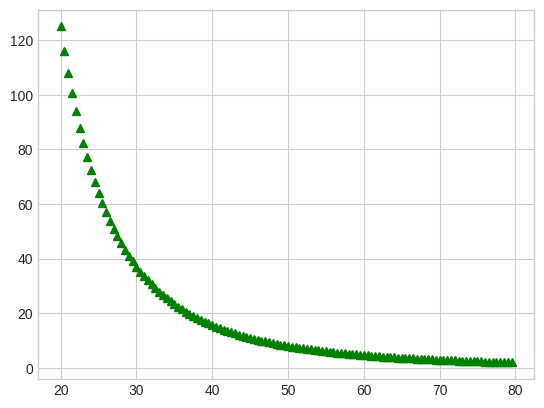

In [235]:
t=np.arange(20,80,0.5)
plt.plot(t,1/((t-0.99*t)**3),'g^')

In [100]:
def animate_path(path, image=None, ax=None, color='0.25', **figure_args):
    def get_position(config):
        return reduce(lambda p, q: (p[0] + q[0], p[1] + q[1]), config, (0, 0))

    if ax is None:
        _, ax = plt.subplots(**figure_args)

    k = 2 ** (len(path[0]) - 1) + 1
    X, Y = (np.vstack([[(0, 0)], np.asarray(config).cumsum(axis=0)])[:-1].T - 0.5)
    U, V = np.asarray(config).T
    ax.quiver(
        X, Y, U, V,
        angles='xy', scale_units='xy', scale=1,
        color=color,
        width=0.005,
        zorder=10,
    )
    point = get_position(config)
    ax.plot(point[0]-0.5, point[1]-0.5, '.', color='k', zorder=11)
    if image is not None:
        ax.matshow(image, extent=[-k-1, k, -k-1, k])
    ax.set_xlim(-k-1, k)
    ax.set_ylim(-k-1, k)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(-k, k+1))
    ax.set_yticks(np.arange(-k, k+1))
    return ax


<AxesSubplot: >

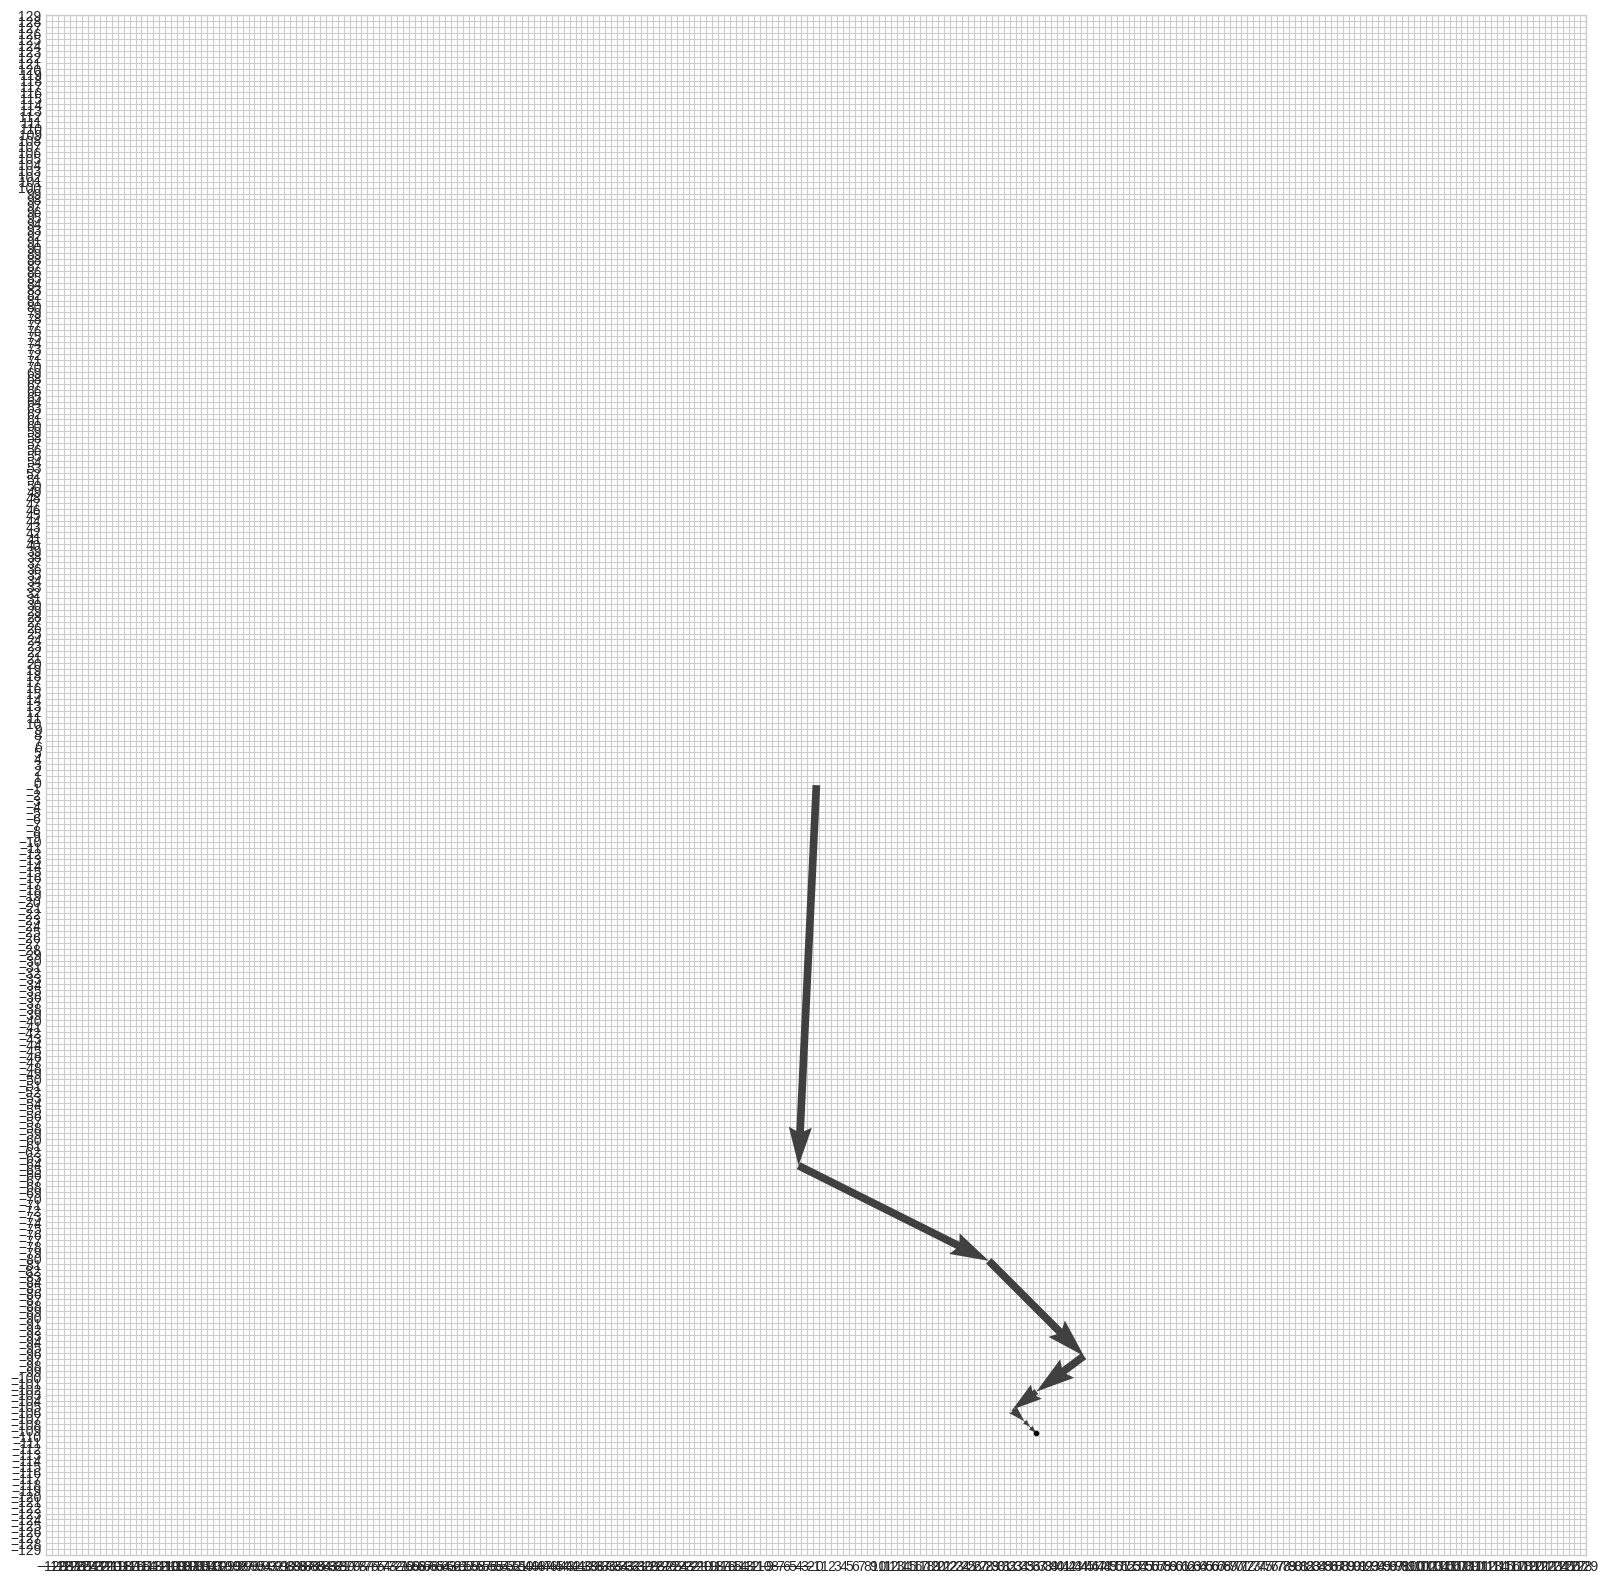

In [261]:
plot_configuration(config[-1],figsize=(20,20))

In [ ]:
# add to dictionary of choices, options from pixels in the array wiehgted by color cost when number of options are 
#low, choices in costs are picked by same distribution, lower cost more likely
#pixels added to options are picked wieighted by similarity in color, so that it is more likely to be taken into dictionary when colour similar to
#current pixel


In [81]:
df_img = pd.read_csv('image.csv')
image = df_to_image(df_img)

0
1
2


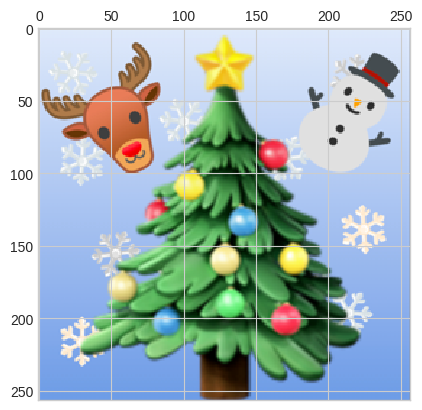

In [83]:

img = image
for x in range(3):
    img[:,:,x]=img[:,:,x]*pix_map
    print(x)
    
plt.matshow(img)    


In [164]:
neigh = get_neighbors(config[-1])
point = (0, 0)
cs = neigh
k = 50
colors = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

fig, ax = plt.subplots(figsize=(100, 100))
for c in cs:
    X, Y = (np.vstack([[(0, 0)], np.asarray(c).cumsum(axis=0)])[:-1].T - 0.5)
    U, V = np.asarray(c).T
    ax.quiver(
        X, Y, U, V,
        angles='xy', scale_units='xy', scale=1,
        color=next(colors),
        width=0.0025,
        zorder=10,
        alpha=0.25,
    )
    point = get_position(c)
    ax.plot(point[0]-0.5, point[1]-0.5, '.', color='k', zorder=11)
point = get_position(config[-1])
ax.plot(point[0]-0.5, point[1]-0.5, 'o', color='C3', zorder=11)
ax.set_xlim(-130, 130)
ax.set_ylim(-130, 130)
ax.set_aspect('equal')
ax.set_xticks(np.arange(-130, 130))
ax.set_yticks(np.arange(-130, 130))
ax.grid(True, color='0.5')
ax.set_title(f"Neighbors of {config[-1]}", fontsize=20);